In [344]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from tqdm import tqdm_notebook
from itertools import product
from scipy import stats
from scipy.stats import norm

In [345]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
sales_train = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
sample_sub = pd.read_csv('sample_submission.csv.gz')
test = pd.read_csv('test.csv.gz')

## First few rows of data, data statistics

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [10]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [11]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [12]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## Downcast data to save memory

In [13]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                `float64` type to `float32`
                `int64`   type to `int32`
    '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
 
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [14]:
sales_train=downcast_dtypes(sales_train)

In [15]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int32
shop_id           int32
item_id           int32
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int32(3), object(1)
memory usage: 78.4+ MB


## Missing values

In [297]:
pd.DataFrame({'feature':sales_train.columns.values,'null percentage':np.array([sales_train[a].isnull().sum() for a in sales_train.columns.values])/sales_train.shape[0]})

,feature,null percentage
0,date,0.0
1,date_block_num,0.0
2,shop_id,0.0
3,item_id,0.0
4,item_price,0.0
5,item_cnt_day,0.0


## Histogram of sales_train['item_price']

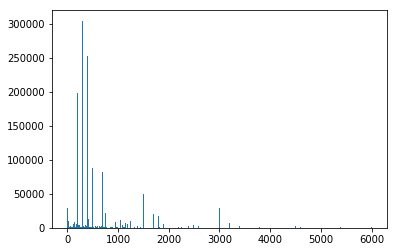

In [16]:
plt.hist(sales_train['item_price'][sales_train['item_price']<=np.percentile(sales_train['item_price'],99)],bins=1000)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.93600e+03, 1.00000e+00, 1.22600e+03, 4.95000e+02, 0.00000e+00,
        2.20000e+01, 0.00000e+00, 1.23500e+03, 2.10000e+01, 1.20000e+02,
        2.99640e+04, 1.00000e+00, 6.00000e+00, 2.30000e+01, 3.20000e+01,
        9.00000e+00, 6.95000e+02, 6.75000e+02, 1.60000e+01, 3.84000e+02,
        7.60000e+01, 1.00860e+04, 2.43600e+03, 2.74000e+02, 5.08000e+02,
        1.00400e+03, 4.86400e+03, 9.38900e+03, 9.40900e+03, 1.55960e+04,
        1.81200e+03, 6.81120e+04, 1.05540e+04, 6.97600e+03, 2.36050e+05,
        3.37100e+04, 2.10877e+05, 1.30440e+04, 1.12822e+05, 1.63690e+04,
        3.22185e+05, 1.26114e+05, 2.78423e+05, 5.85820e+04, 1.37516e+05,
        1.23339e+05, 1.16143e+05, 1.13295e+05, 8.36170e+04, 1.13672e+05,
        5.08500e+04, 1.08675e+05, 8.83220e+04, 5.47440e+04, 3.55710e+04,
        7.94280e+04, 4.28640e+04, 7.35450e+04, 4.82980e+04, 2.31960e+04,
        1.21240e+04, 7.22400e+03, 4.40800e+03, 3.59

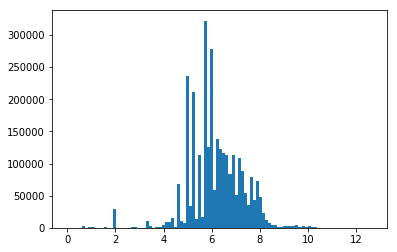

In [269]:
plt.hist(np.log(sales_train['item_price']+2),bins=100)

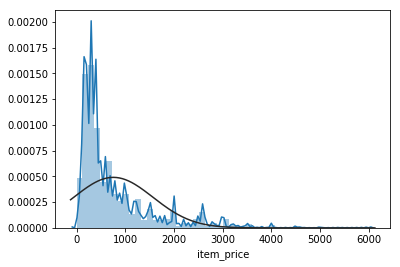

In [349]:
sns.distplot(sales_train['item_price'][sales_train['item_price']<=np.percentile(sales_train['item_price'],99)], fit=norm)

## Explore sales_train['item_price']

In [21]:
sales_train['item_price'].value_counts()

299.000000     291352
399.000000     242603
149.000000     218432
199.000000     184044
349.000000     101461
599.000000      95673
999.000000      82784
799.000000      77882
249.000000      77685
699.000000      76493
499.000000      73078
899.000000      57156
1199.000000     55448
1999.000000     49672
99.000000       48955
2599.000000     47857
1499.000000     47196
449.000000      43205
549.000000      39080
5.000000        29702
2999.000000     28929
1299.000000     22381
169.000000      20848
1699.000000     18924
1099.000000     17645
749.000000      17351
1799.000000     17292
2499.000000     16713
1399.000000     15694
1599.000000     14293
                ...  
2684.510010         1
2678.949951         1
2677.571533         1
2710.000000         1
2710.939941         1
2712.110107         1
2735.419922         1
2750.544922         1
2750.510010         1
2749.500000         1
418.095245          1
2748.833252         1
2748.500000         1
2748.399902         1
2747.90918

In [284]:
sales_count = sales_train['item_cnt_day'].value_counts()
sales_count

 1.0      2629372
 2.0       194201
 3.0        47350
 4.0        19685
 5.0        10474
-1.0         7252
 6.0         6338
 7.0         4057
 8.0         2903
 9.0         2177
 10.0        1820
 11.0        1263
 12.0        1083
 13.0         918
 14.0         716
 15.0         638
 16.0         544
 17.0         438
 18.0         391
 20.0         364
 19.0         347
 21.0         290
 22.0         242
 24.0         204
 23.0         198
 25.0         180
 26.0         176
 30.0         147
 28.0         131
 27.0         130
           ...   
 95.0           1
 96.0           1
 102.0          1
 105.0          1
 109.0          1
 112.0          1
 113.0          1
 118.0          1
 128.0          1
 129.0          1
 131.0          1
 132.0          1
 135.0          1
 146.0          1
 200.0          1
 147.0          1
 149.0          1
 153.0          1
 154.0          1
 156.0          1
 157.0          1
 504.0          1
 163.0          1
 164.0          1
 167.0    

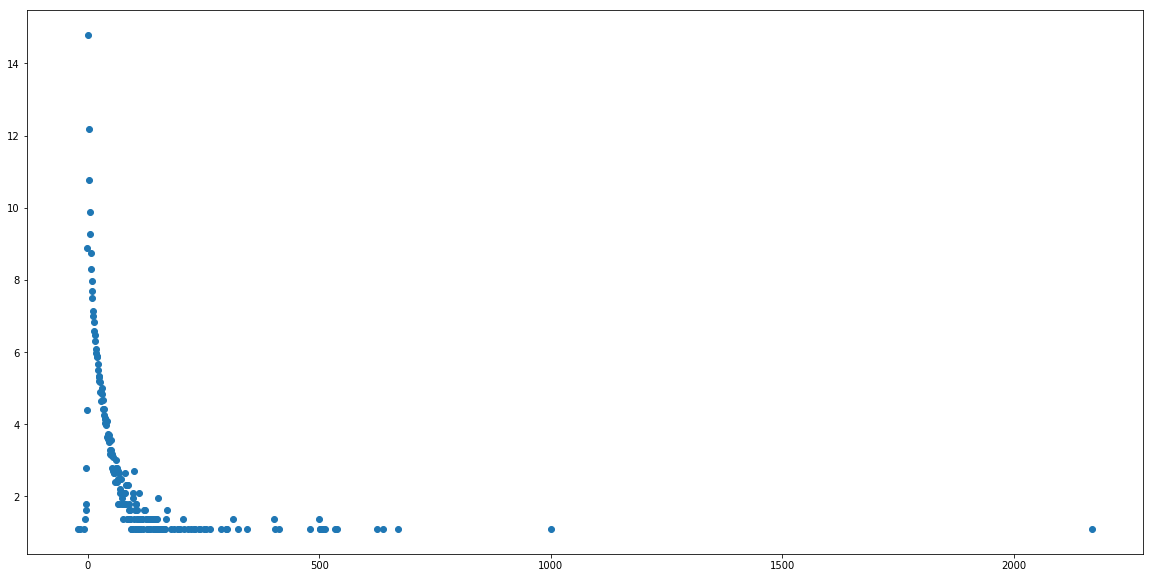

In [286]:
plt.figure(figsize=(20,10))
sales_count = sales_train['item_cnt_day'].value_counts()
aaa=np.log(sales_count.values+2)
plt.scatter(sales_count.index,aaa)

## Explore the relationship between 'item_cnt_day' and 'month'
### In summary:
- found seasonality: consider generating features utilizing this seasonality (such as 'prophet' forecasting?)

In [98]:
a = sales_train.groupby('date',as_index=False)['item_cnt_day'].sum()

In [99]:
a['month'] = [aa[3:5] for aa in a['date']]
a['day'] = [aa[0:2] for aa in a['date']]
a['year'] = [aa[6:10] for aa in a['date']]

In [100]:
a['year_month'] = a['year']+'_'+a['month']

In [101]:
b = a.groupby('year_month',as_index=False)['item_cnt_day'].sum()

In [102]:
b.sort_values(by=['year_month'])

,year_month,item_cnt_day
0,2013_01,131479.0
1,2013_02,128090.0
2,2013_03,147142.0
3,2013_04,107190.0
4,2013_05,106970.0
5,2013_06,125381.0
6,2013_07,116966.0
7,2013_08,125291.0
8,2013_09,133332.0
9,2013_10,127541.0


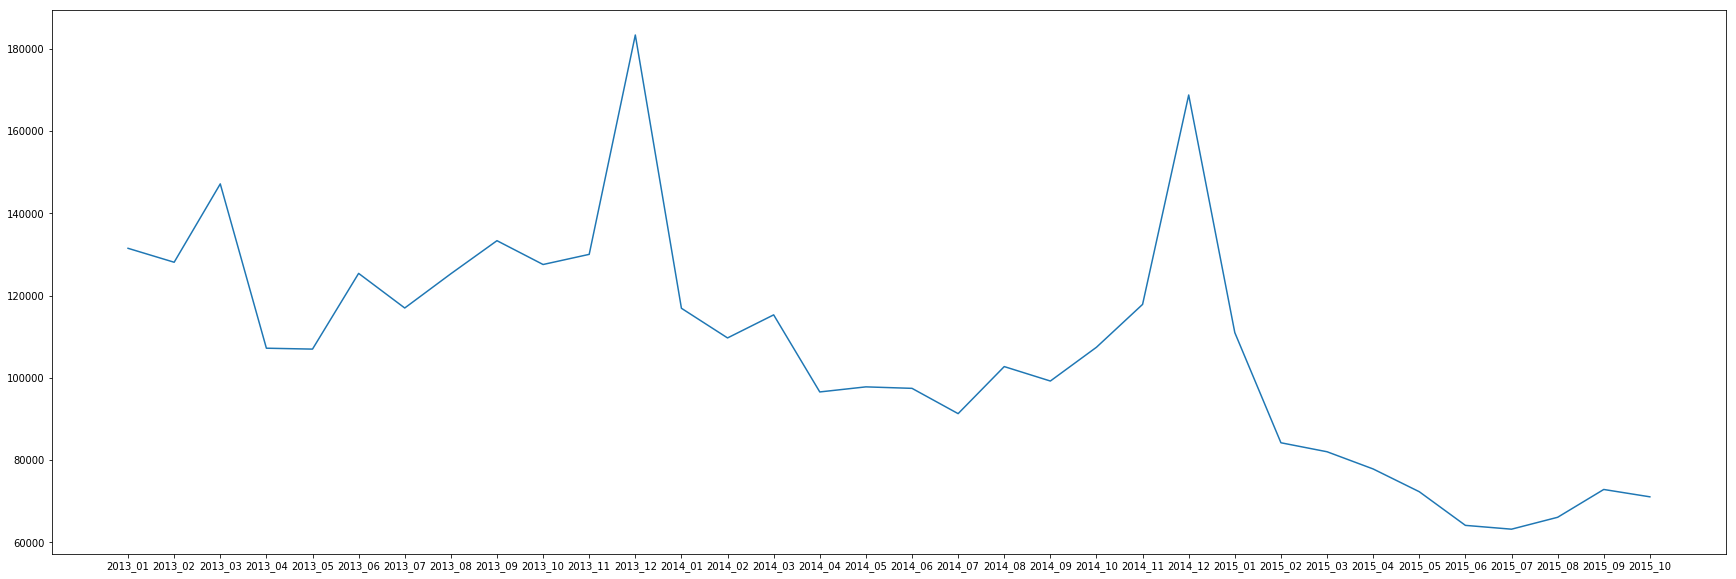

In [104]:
plt.figure(figsize=[30,10])
plt.plot(b['year_month'],b['item_cnt_day'])

## Explore any difference between test data distribution and training data distribution:
### In summary 
- test data has some new item_ids not found in training data
- test data is missing some shop_ids found in training data

### Check unique shop_id's in training and test data

In [115]:
np.sort(sales_train.shop_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

In [116]:
np.sort(test.shop_id.unique())

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

### Test data is missing these shop_id's

In [129]:
[x for x in np.sort(sales_train.shop_id.unique()) if x not in np.sort(test.shop_id.unique())]

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]

In [290]:
sales_train[sales_train.shop_id.isin([0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54])].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,522603.000000,522603.000000,522603.000000,522603.000000,522603.000000
mean,11.962618,36.321805,10537.915339,824.074768,1.258692
std,8.393854,14.909747,6323.295740,1586.129761,2.018859
min,0.000000,0.000000,0.000000,-1.000000,-5.000000
25%,4.000000,27.000000,4870.000000,210.000000,1.000000
50%,11.000000,30.000000,10160.000000,399.000000,1.000000
75%,19.000000,54.000000,16069.000000,899.000000,1.000000
max,33.000000,54.000000,22168.000000,35490.000000,502.000000


In [291]:
sales_train[sales_train.shop_id.isin([0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54])]['item_id'].isin(test.item_id).describe()

count     522603
unique         2
top        False
freq      301036
Name: item_id, dtype: object

In [292]:
sales_train[sales_train.shop_id.isin([0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54])]['item_id'].isin(test.item_id).sum()

221567

### Check difference of shop_id's: test set and validation set

In [135]:
np.sort(sales_train[sales_train['date_block_num']==33].shop_id.unique())

array([ 2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22,
       24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47,
       48, 49, 50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [137]:
[x for x in np.sort(sales_train[sales_train['date_block_num']==33].shop_id.unique()) if x not in np.sort(test.shop_id.unique())]

[9, 20]

### Check difference of item_id's: test set and training set

In [153]:
test.item_id.isin(sales_train.item_id).describe()

count     214200
unique         2
top         True
freq      198954
Name: item_id, dtype: object

## Scatterplot of 'item_price' and 'item_cnt_day'
- found outlier: item_price over 300000, item_cnt_day  over 2000

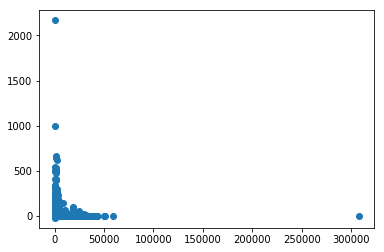

In [324]:
plt.scatter(sales_train['item_price'],sales_train['item_cnt_day'])

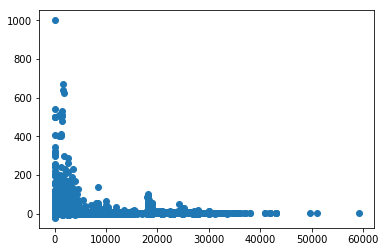

In [340]:
filter = (sales_train['item_price']<300000) & (sales_train['item_cnt_day'] < 2000)
plt.scatter(sales_train['item_price'][filter],sales_train['item_cnt_day'][filter])

## Pairplot

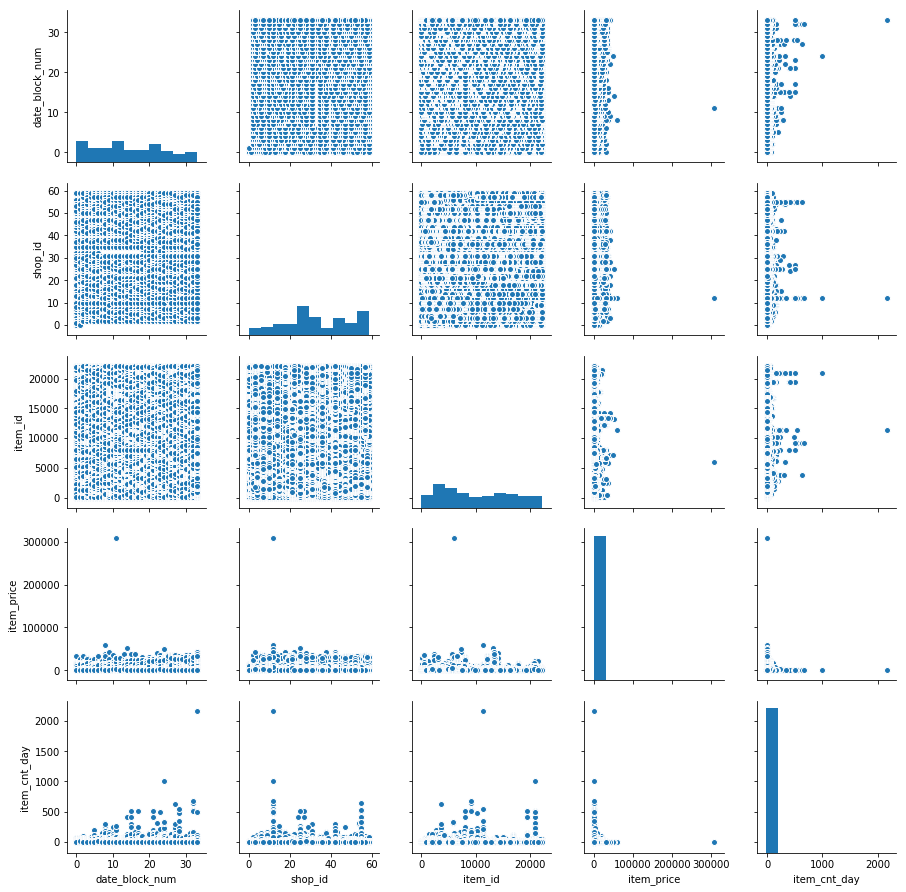

In [221]:
sns.pairplot(sales_train, size = 2.5)

## Correlation heatmap

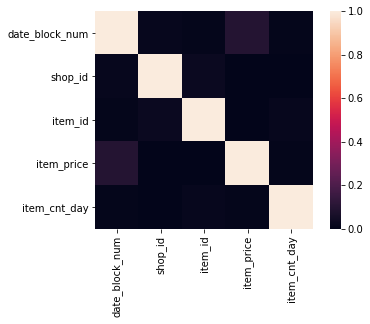

In [222]:
corrmat = sales_train.corr()
sns.heatmap(corrmat, vmin=0, vmax=1, square=True);

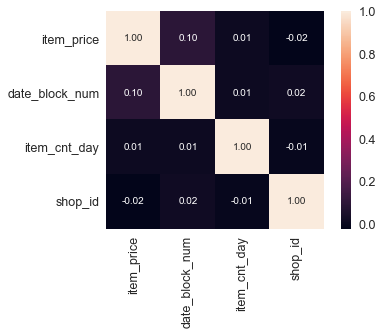

In [380]:
# Select first 4 features that correlate with 'item_price' most and draw correlation map with correlation coefficients annotated 
k=4
cols=corrmat.nlargest(k, 'item_price')['item_price'].index
cm = sales_train[cols].corr() # or cm = np.corrcoef(sales_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [298]:
sales_train.dtypes

date               object
date_block_num      int32
shop_id             int32
item_id             int32
item_price        float32
item_cnt_day      float32
dtype: object

## Boxplot：1: shop_id vs. item_price; 2: shop_id vs. item_cnt_day

(-0.5, 59.5, 0, 3000)

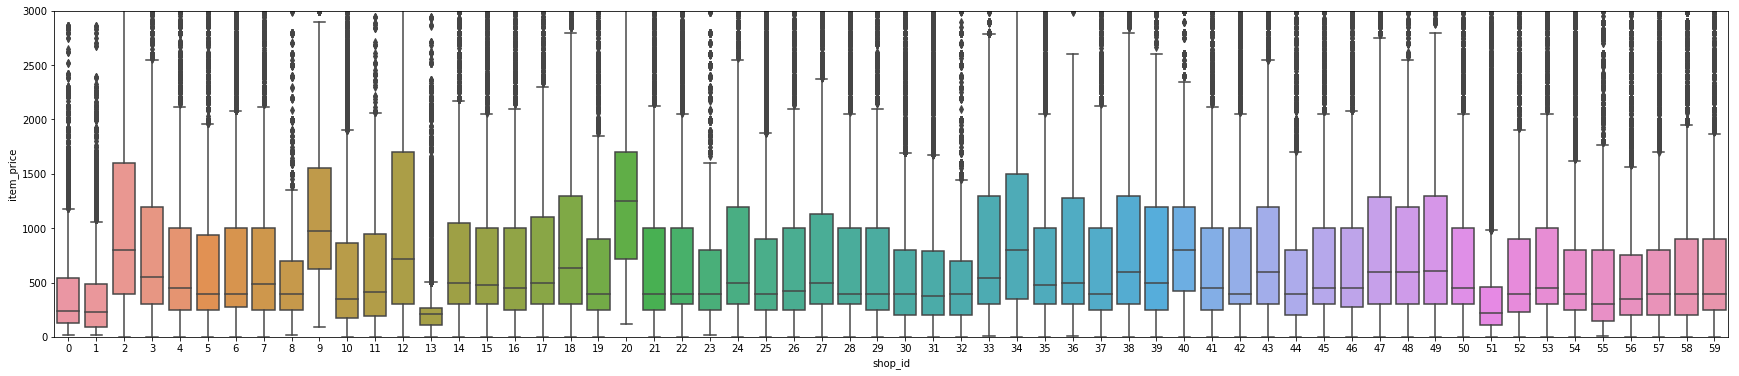

In [314]:
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x='shop_id', y="item_price", data=sales_train.sort_values(['shop_id']))
fig.axis(ymin=0, ymax=3000)

(-0.5, 59.5, 0, 10)

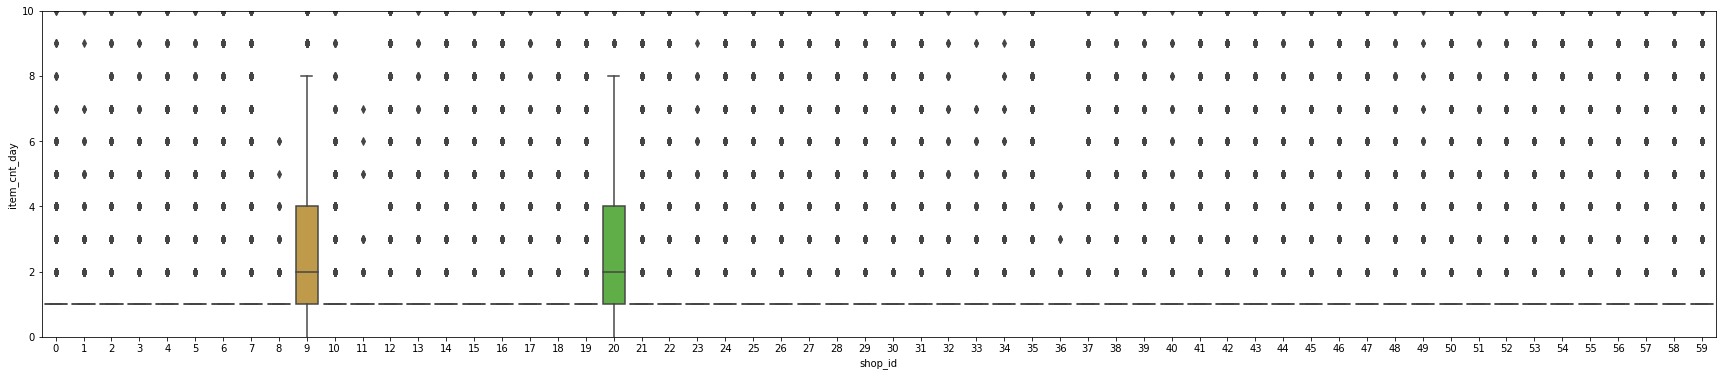

In [321]:
f, ax = plt.subplots(figsize=(30, 6))
fig2 = sns.boxplot(x='shop_id', y="item_cnt_day", data=sales_train.sort_values(['shop_id']))
fig2.axis(ymin=0, ymax=10)